**CS22_01_PFC**

# Libraries

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import triku as tk

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.8 anndata==0.9.2 umap==0.5.3 numpy==1.24.4 scipy==1.8.0 pandas==1.2.4 scikit-learn==1.1.1 statsmodels==0.13.2 igraph==0.9.10 pynndescent==0.5.7


In [3]:
results_file = '/group/testa/Project/CBOProgPools/h5ad/CS22_01_20240208_v1.h5ad'  # the file that will store the analysis results

In [4]:
geschwind_ext = {
  'astrocytes' : ['S100B','AQP4'],
  'pericyte' : ['RGS5'],
  'microglia' : ['AIF1'],
  'endothelial' : ['ITM2A','CLDN5','ESAM'],
  'ExcDeepLayer' : ['SOX5'],
  'Interneurons' : ['DLX1','DLX2','DLX5'],
  'MatUpperEnr' : ['STMN2','SATB2','LMO4'],
  'IP' : ['PPP1R17','SSTR2','EOMES','PENK'],
  'MatExc' : ['SATB2','STMN2'],
  'MigExc' : ['POU3F2'],
  'CycProg' : ['HMGB2','SOX2','MKI67','PCNA'],
  'OPCs' : ['PTPRZ1','OLIG1','PDGFRA'],
  'RG' : ['VIM','PTPRZ1','SOX2','SLC1A3','HES1','HOPX'],
  'Exc_CAMK2A+' : ['CAMK2A'],
  'Exc_TBR1+' : ['TBR1']
}

In [5]:
# Read in the count matrix into an AnnData object, which holds many slots for annotations and different representations
# of the data. It also comes with its own HDF5-based file format: .h5ad.
adata = sc.read_10x_mtx(
    '/group/testa/Project/CBOProgPools/data/CS22_PFC/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/group-testa-Project-CBOProgPools-data-CS22_PFC-matrix.h5ad


In [6]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [7]:
adata

AnnData object with n_obs × n_vars = 1945 × 33694
    var: 'gene_ids'

# Data Preparation

normalizing counts per cell
    finished (0:00:00)


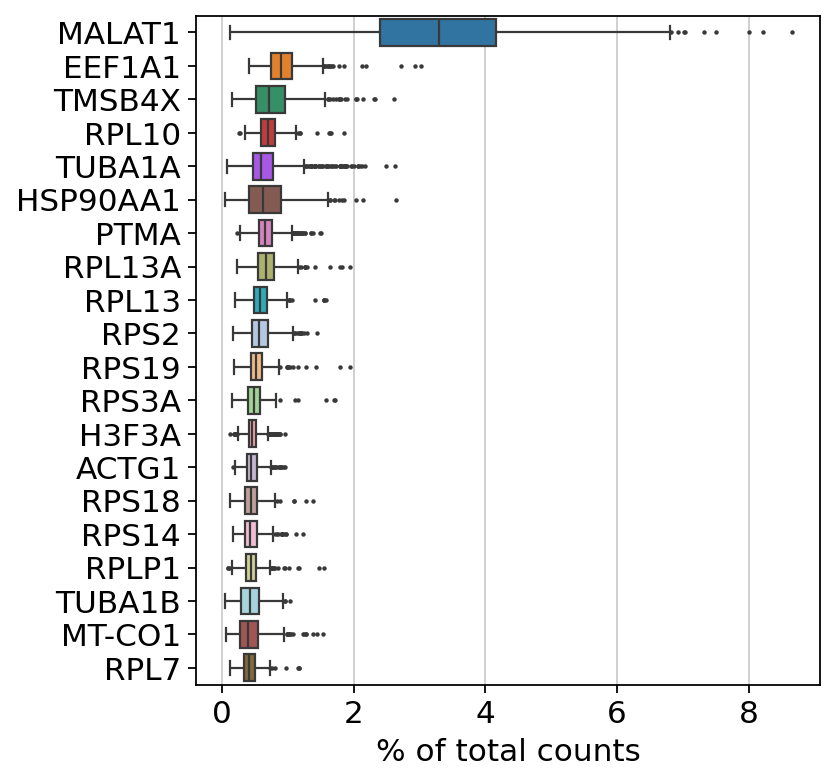

In [30]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20, )


In [31]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=50)

filtered out 22516 genes that are detected in less than 50 cells


In [32]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adata.var['ribo'] = adata.var_names.str.startswith('RPL')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)

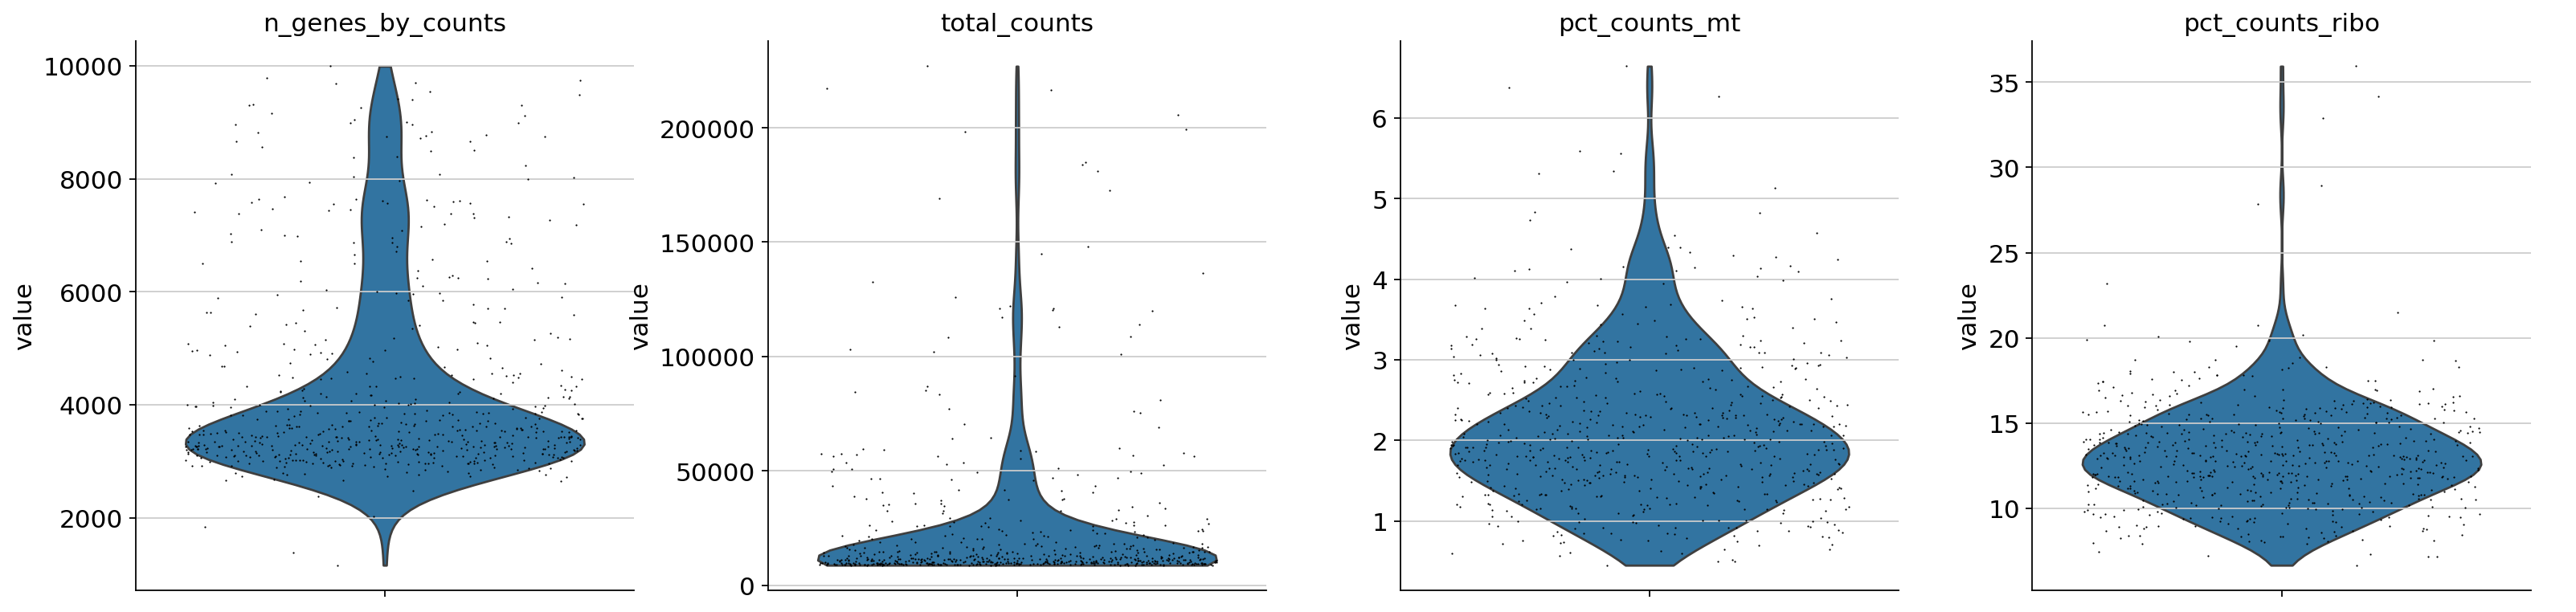

In [33]:
# A violin plot of some of the computed quality measures:
   # the number of genes expressed in the count matrix
   # the total counts per cell
   # the percentage of counts in mitochondrial genes

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
             jitter=0.4, multi_panel=True)

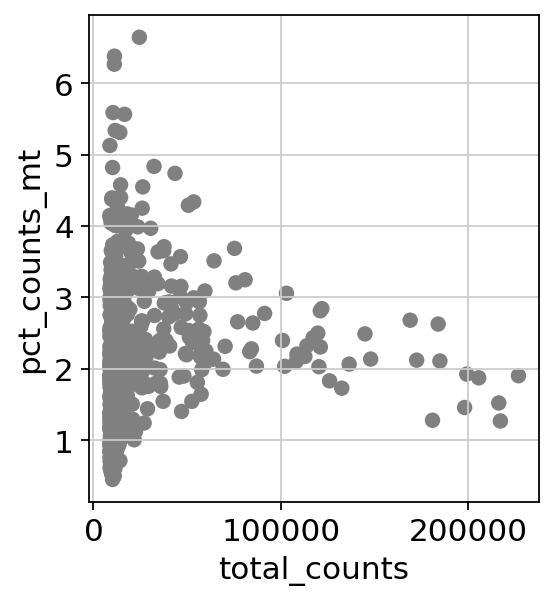

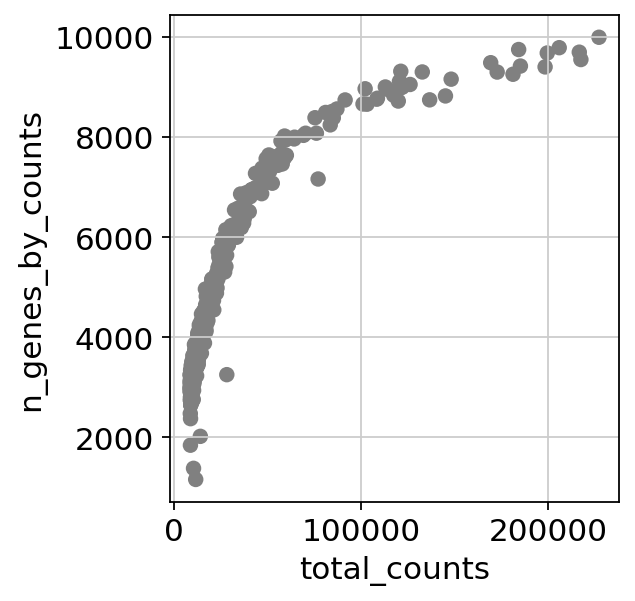

In [34]:
# Remove cells that have too many mitochondrial genes expressed or too many total counts:

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [35]:
adata = adata[adata.obs.total_counts <= 20000]

In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [ ]:
s_genes = pd.read_csv("/group/testa/Project/CBOProgPools/ReferenceFiles/S_genes",index_col=0,header=None)
g2m_genes = pd.read_csv("/group/testa/Project/CBOProgPools/ReferenceFiles/G2M_genes",index_col=0,header=None)
sc.tl.score_genes_cell_cycle(adata,s_genes.index,g2m_genes.index)

In [ ]:
adata.obs.keys()

In [ ]:
adata.obs.phase.value_counts()

In [ ]:
sc.external.pp.scrublet(adata)

In [19]:
adata.obs.predicted_doublet.value_counts()

False    1931
True        7
Name: predicted_doublet, dtype: int64

In [20]:
adata.raw = adata.copy()
adata.layers['Raw'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=20000) # highest meaningful coverage (see tot_counts)
adata.layers['normalized'] = adata.X.copy()
sc.pp.log1p(adata)
adata.layers['logNorm'] = adata.X.copy()

normalizing counts per cell
    finished (0:00:00)


In [21]:
adata

AnnData object with n_obs × n_vars = 1938 × 10628
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo'
    uns: 'scrublet', 'log1p'
    layers: 'Raw', 'normalized', 'logNorm'

In [22]:
sc.pp.pca(adata, use_highly_variable=False)

sc.pp.neighbors(adata, metric='cosine', n_neighbors=int(0.5 * len(adata) ** 0.5)) #25 , 50. 75, 100
 
## Triku

tk.tl.triku(adata, use_raw=False)

Top20Triku = adata.var.sort_values(by=['triku_distance'], ascending=False).head(20).index
Top20Triku

computing PCA
    with n_comps=50
    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)



KeyboardInterrupt



In [ ]:
adata.var_names[adata.var['highly_variable'] == True]

# Principle Component Analysis

In [ ]:
# Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main 
# axes of variation and denoises the data.
sc.tl.pca(adata, svd_solver='arpack',use_highly_variable=True)

In [ ]:
# We can make a scatter plot in the PCA coordinates, but we will not use that later on.

# MKI67 = cycling cell (usually progenitors, aRG / bRG / IP)
# EOMES = IP specific
# SLC1A3 = Radial Glia in general, including glia
# HOPX = bRG specific
# DCX = immature neurons
# STMN2 neurons in general

sc.pl.pca(adata, color=['MKI67','SLC1A3','STMN2'],use_raw=False,vmin="p1",vmax="p99") # ??????????????????????

In [ ]:
# Let us inspect the contribution of single PCs to the total variance in the data. 
# This gives us information about how many PCs we should consider in order to compute 
# the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() 
# or tSNE sc.tl.tsne(). In our experience, often a rough estimate of the number of PCs does fine.
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
# saving the result
adata.write(results_file)

In [ ]:
adata

# Computing Neighborhood Graph 

In [ ]:
int(0.5 * len(adata) ** 0.5)

In [ ]:
# Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. 
# You might simply use default values here. For the sake of reproducing Seurat’s results, let’s take the following values.
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=15)

# Embedding Neighborhood Graph

In [ ]:
sc.tl.leiden(adata,resolution=0.5,key_added="leiden")
# small resolution ==> less clusters 
# 0.4 - 1.5

In [ ]:
adata.obs.leiden.value_counts()

In [ ]:
# We suggest embedding the graph in two dimensions using UMAP (McInnes et al., 2018), see below. 
# It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it 
# better preserves trajectories. In some ocassions, you might still observe disconnected clusters and
# similar connectivity violations. They can usually be remedied by running:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

In [ ]:
sc.tl.umap(adata)

In [ ]:
# As we set the .raw attribute of adata, the previous plots showed the “raw” (normalized, logarithmized, but uncorrected) 
# gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don’t want to 
# use .raw.
sc.pl.umap(adata, color=['MKI67','SLC1A3','STMN2'], use_raw=False,vmin="p1",vmax="p99")

# Clustering Neighborhood Graph

In [ ]:
# Plot the clusters, which agree quite well with the result of Seurat.
#sc.pl.umap(adata, color=['leiden', 'MKI67','SLC1A3','STMN2'])

In [ ]:
# saving results
adata.write(results_file)

# Finding Gene Markers

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

In [ ]:
adata.write(results_file)

In [ ]:
sc.pl.umap(adata,color=["leiden","phase"])

In [ ]:
sc.pl.violin(adata, ['MKI67', 'SLC1A3','STMN2'], groupby='leiden',use_raw=False)

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

In [ ]:

marker_genes = ['leiden','MEIS2', 'ID4','NFIA','PRDX1','RAB13','RPLP0','RPL41','ASPM','TOP2A','BCL11B','NEUROD6', 'HMGB1', 'H2AFZ','STMN2', 'MLLT11', 'NEUROG2','GADD45G', 'RSPO3', 'VIM']



In [ ]:
sc.pl.umap(adata,color=marker_genes,vmin="p1",vmax="p99",use_raw=False)

In [ ]:
sc.tl.diffmap(adata)

In [ ]:
sc.pl.diffmap(adata,color=["leiden", 'STMN2','MKI67', 'EZH2', 'EOMES'],dimensions=(1,2),vmin='p1',vmax='p99',use_raw=False)

In [ ]:
sc.pl.umap(adata,color=["leiden", "STMN2", "MKI67", "EOMES"],vmin="p1",vmax="p99",use_raw=False)

In [ ]:
sc.tl.leiden(adata,resolution=0.5,key_added="leiden")

In [ ]:
geschwind_ext = {
  'ExcDeepLayer' : ['SOX5'],
  'MatUpperEnr' : ['STMN2','LMO4'],
  'IP' : ['PPP1R17','SSTR2','EOMES','PENK'],
  'MatExc' : ['STMN2'],
  'MigExc' : ['POU3F2'],
  'CycProg' : ['HMGB2','SOX2','MKI67','PCNA'],
  'OPCs' : ['PTPRZ1'],
  'RG' : ['VIM','PTPRZ1','SOX2','SLC1A3','HES1','HOPX'],
  'Exc_TBR1+' : ['TBR1']
}
 
sc.pl.dotplot(adata,geschwind_ext , 'leiden', dendrogram=True,save="combo_markersDotplot",use_raw=False,log=True,standard_scale='var')

In [ ]:
### DONE BUT NOT REV.


cluster2annotation = {
    "0": "RG", "1": "Neu","2":"RG", "3": "RG",
    "4": "RG", "5" : "Neu", "6" : "RG", "7" : "Neu",
    "8" : "IP", "9" : "RG"
    
}
 
adata.obs['celltype'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

In [ ]:
### DONE BUT NOT REV.

## all vRG bcs they dont have HOPX ? or yes????
## cluster 2 doesnt have PTPRZ1... is this important???

cluster2annotation = {
     "0": "vRG", "1": "MatExc","2":"vRG", "3": "oRG",
    "4": "vRG", "5" : "MatExc", "6" : "vRG", "7" : "MatExc",
    "8" : "IP", "9" : "vRG"
}
 
adata.obs['celltype2'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

In [ ]:
### DONE BUT NOT REV.

new_cluster_names = [
    '0/vRG', '1/MatExc',
    '2/vRG', '3/oRG',
    '4/vRG','5/MatExc', '6/vRG', '7/MatExc',
    '8/IP','9/vRG']
adata.rename_categories('leiden', new_cluster_names)

In [ ]:
sc.pl.umap(adata, color=['leiden','celltype','celltype2'], legend_loc='on data', title='', frameon=False, save='.pdf')

In [ ]:
sc.pl.umap(adata,color=['pct_counts_mt','total_counts'],vmin='p1',vmax='p99')

In [ ]:
sc.tl.dendrogram(adata,"leiden")
#sc.pl.dotplot(adata, marker_genes, groupby='leiden',use_raw=False,log=True,standard_scale='var',dendrogram=True)

In [ ]:
sc.tl.diffmap(adata)

In [ ]:
adata.obs.leiden.value_counts()

In [ ]:
sc.tl.diffmap(adata)

In [ ]:
# no adata_check bcs no endo, pery... 
sc.pl.diffmap(adata,color="leiden",dimensions=(1,2))

In [ ]:
adata.obs.leiden

In [ ]:
adata.write_h5ad("/group/testa/Project/CBOProgPools/h5ad/CS22_01_20240208_v1.h5ad")

In [ ]:
adata=sc.read_h5ad("/group/testa/Project/CBOProgPools/h5ad/CS22_01_20240208_v1.h5ad")

In [ ]:
adata.obs['stage'] = 'CS22'

In [ ]:
adata.write_h5ad('/group/testa/Project/CBOProgPools/h5ad/CS22_01_20240208_v1.h5ad')